In [1]:
!pip install gurobipy
!pip install numpy
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array, check_X_y

In [3]:
def ancestors(t):
    """Returns the ancestors of node t for which t is on the left (A_l) or right (A_r) path"""
    A_l = []
    A_r = []
    while t > 1:
        if t % 2 == 0:
            A_l.append(t // 2)
        else:
            A_r.append(t // 2)
        t //= 2
    return A_l, A_r

In [4]:
def plot_estimator(estimator, X, y, ax=None, steps=300, colors=("b", "r")):
    """
    Plot a scikit-learn estimator and samples for a 2D dataset. Uses matplotlib.
    Parameters
    ----------
    estimator : Scikit-learn compatible estimator
        Estimator to visualize
    X : array-like of shape (n_samples, n_features)
        Feature values.
    y : array-like of shape (n_samples,)
        Ground truth targets.
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on.
    """
    if X.shape[1] != 2:
        raise ValueError("X must be 2D")

    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3))

    x_low = np.min(X[:, 0])
    x_high = np.max(X[:, 0])
    y_low = np.min(X[:, 1])
    y_high = np.max(X[:, 1])

    x_extra = (x_high - x_low) * 0.1
    y_extra = (y_high - y_low) * 0.1

    x_low -= x_extra
    x_high += x_extra
    y_low -= y_extra
    y_high += y_extra

    xx, yy = np.meshgrid(
        np.linspace(x_low, x_high, steps), np.linspace(y_low, y_high, steps)
    )

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.25, levels=1, colors=colors)
    ax.scatter(X[y == 0, 0], X[y == 0, 1], marker="_", c=colors[0])
    ax.scatter(X[y == 1, 0], X[y == 1, 1], marker="+", c=colors[1])

    ax.set_xlim(x_low, x_high)
    ax.set_ylim(y_low, y_high)

In [5]:
class MilpDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3):
        self.max_depth = max_depth

    def fit(self, X, y):
        check_X_y(X, y, y_numeric=True)

        (
            self.features_,
            self.threshold_,
            self.value_,
            self.children_left_,
            self.children_right_,
            self.model_tree_vars_,
        ) = fit_model(X, y, self.max_depth)

    def get_abc(self):
        return self.model_tree_vars_

    def predict(self, X):
        check_array(X)

        predictions = np.empty(len(X))

        for i, x in enumerate(X):
            node = 0
            while self.children_left_[node] != self.children_right_[node]:
                if np.dot(x, self.features_[node]) <= self.threshold_[node]:
                    node = self.children_left_[node]
                else:
                    node = self.children_right_[node]

            predictions[i] = self.value_[node]

        return predictions

    def predict_proba(self, X):
        predictions = self.predict(X)

        return np.concatenate((1 - predictions[:, None], predictions[:, None]), axis=1)

In [6]:
def fit_model(X, y, max_depth):
    """
    Train the decision tree by translating the learning problem
    into Mixed-Integer Linear Programming (MILP) and solve it
    to get the optimal solution.

    The features of X have already been scaled to the range [0, 1].
    """

    model = gp.Model("Optimal_decision_tree")

    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    n_nodes = (2**max_depth) - 1
    n_leaves = 2**max_depth

    nodes = range(1, n_nodes + 1)
    leaves = range(n_nodes + 1, n_nodes + n_leaves + 1)

    # Create the decision variables for the solver:
    # a[j, m]:  whether or not feature j is selected for decision node m (0 or 1)
    # b[m]:     the threshold value of decision node m (between 0 and 1)
    # c[t]:     the prediction of decision leaf t (0 or 1)
    # e[i]:     whether or not the prediction of sample i is erroneous (0 or 1)
    # f[i, m]:  an alias for a dot product x
    # z[i, t]:  sample i does / doesn't end up in leaf t (0 or 1)
    a = model.addVars(n_features, nodes, vtype=GRB.BINARY, name="a")
    b = model.addVars(nodes, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="b")
    c = model.addVars(leaves, n_classes, vtype=GRB.BINARY, name="c")
    e = model.addVars(n_samples, vtype=GRB.CONTINUOUS, name="e")
    f = model.addVars(n_samples, nodes, vtype=GRB.CONTINUOUS, name="f")
    z = model.addVars(n_samples, leaves, vtype=GRB.BINARY, name="z")

    # Create the constraints
    epsilon = 0.0001

    #########################################
    ### TODO: place your constraints here ###
    #########################################

    # The objective is to mimize the number of errors
    model.setObjective(e.sum(), GRB.MINIMIZE)

    # Write the MILP model to a file for easier debugging
    model.write("milp.lp")

    # Solve the model to find the optimal tree
    model.optimize()

    if model.Status == GRB.INFEASIBLE:
        raise RuntimeError(
            "Your model is infeasible which means the constraints cannot be satisfied"
        )

    # Turn the results from the solver into a format that is easy
    # to make predictions with at test time for more details see:
    # https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    features = np.full((n_nodes + n_leaves, n_features), -1, dtype=float)
    threshold = np.full(n_nodes + n_leaves, -1, dtype=float)
    value = np.full(n_nodes + n_leaves, -1, dtype=float)
    children_left = np.full(n_nodes + n_leaves, -1)
    children_right = np.full(n_nodes + n_leaves, -1)

    for m in nodes:
        features[m - 1] = [a[j, m].X for j in range(n_features)]
        threshold[m - 1] = b[m].X

    for t in leaves:
        value[t - 1] = np.argmax([c[t, k].X for k in range(n_classes)])

    for node in nodes:
        children_left[node - 1] = (node * 2) - 1
        children_right[node - 1] = node * 2

    # NOTE: we process a, b and c here such that they map to the value of the solution
    # if you do not process it like this the model will get deleted by garbage collection
    # and the var.X attributes will be gone.
    a = {k: v.X for k, v in a.items()}
    b = {k: v.X for k, v in b.items()}
    c = {k: v.X for k, v in c.items()}

    return features, threshold, value, children_left, children_right, (a, b, c)

In [7]:
# Load some simple 2D data
noise = 0.1  # Try: 0.1 and 0.4
X_train, y_train = make_moons(n_samples=100, noise=noise, random_state=0)
X_test, y_test = make_moons(n_samples=100, noise=noise, random_state=1)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1637 columns and 0 nonzeros
Model fingerprint: 0x16589dd4
Variable types: 807 continuous, 830 integer (830 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


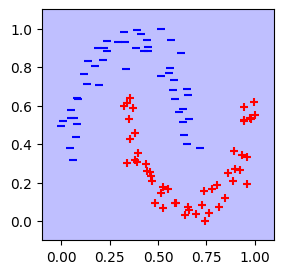

In [14]:
# Define the model, then train and plot it
tree = MilpDecisionTreeClassifier(max_depth=3)

tree.fit(X_train, y_train)

plot_estimator(tree, X_train, y_train)

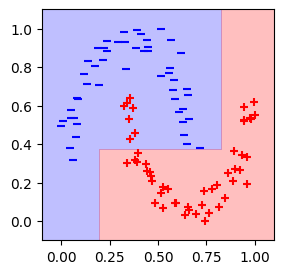

In [9]:
# Define the model, then train and plot it
cart_tree = DecisionTreeClassifier(max_depth=3)

cart_tree.fit(X_train, y_train)

plot_estimator(cart_tree, X_train, y_train)

# Computing robustness using adversarial attacks

In [3]:
!pip install roct

  Using cached roct-0.0.3-py3-none-any.whl
  Using cached numpy-1.21.0.zip (10.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached groot_trees-0.0.16-py3-none-any.whl
  Using cached python_sat-0.1.8.dev9-cp311-cp311-macosx_13_0_x86_64.whl (1.4 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached numba-0.57.1-cp311-cp311-macosx_10_9_x86_64.whl (2.5 MB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
  Using cached pandas-2.1.0-cp311-cp311-macosx_10_9_x86_64.whl (12.0 MB)
  Using cached pandas-2.0.3-cp311-cp311-macosx_10_9_x86_64.whl (11.6 MB)
  Using cached pandas-2.0.2-cp311-cp311-macosx_10_9_x86_64.whl (11.6 MB)
  Using cached pandas-2.0.0-cp311-cp311-macosx_10_9_x86_64.whl (11.6 MB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_10_9_x86_64.whl (11.9 MB)
  Using cach


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [10]:
def attack_tree(a, b, c, X, y, max_depth, perturbation_radius):
    """
    Attack the decision tree by translating the finding adversarial
    perturbations into an MILP formulation.

    This function receives a, b and c, the variables of a the
    model that we defined before. And the dataset (X, y).

    The features of X have already been scaled to the range [0, 1].

    Returns the dataset X perturbed to maximize errors.
    """

    model = gp.Model("Optimal_decision_tree")

    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    n_nodes = (2**max_depth) - 1
    n_leaves = 2**max_depth

    nodes = range(1, n_nodes + 1)
    leaves = range(n_nodes + 1, n_nodes + n_leaves + 1)

    # These are the same variables that we used before:
    # a[j, m]:  whether or not feature j is selected for decision node m (0 or 1)
    # b[m]:     the threshold value of decision node m (between 0 and 1)
    # c[t]:     the prediction of decision leaf t (0 or 1)
    # e[i]:     whether or not the prediction of sample i is erroneous (0 or 1)
    # f[i, m]:  an alias for a dot product x
    # z[i, t]:  sample i does / doesn't end up in leaf t (0 or 1)
    e = model.addVars(n_samples, vtype=GRB.CONTINUOUS, name="e")
    f = model.addVars(n_samples, nodes, vtype=GRB.CONTINUOUS, name="f")
    z = model.addVars(n_samples, leaves, vtype=GRB.BINARY, name="z")

    # We add two new variable:
    # w[i, t]:  whether or not sample i gets wrongly predicted in leaf t
    # x[i, j]:  the value of sample i for feature j
    w = model.addVars(n_samples, leaves, vtype=GRB.BINARY, name="w")
    x = model.addVars(n_samples, n_features, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")

    # Create the constraints
    epsilon = 0.0001

    # NOTE: since we passed the dicts with constants a, b and c, expressions 
    # like a[j, m] will select the value of this variable after the last solve. 
    # This means that we get a constant value and so we are not performing 
    # products between variables (that would make this MILP quadratic).

    #########################################
    ### TODO: place your constraints here ###
    #########################################

    # The attacker's objective is to maximize the number of errors
    model.setObjective(e.sum(), GRB.MAXIMIZE)

    # Write the MILP model to a file for easier debugging
    model.write("milp_attack.lp")

    # Solve the model to find the optimal tree
    model.optimize()

    if model.Status == GRB.INFEASIBLE:
        raise RuntimeError(
            "Your model is infeasible which means the constraints cannot be satisfied"
        )
    
    X_adv = np.array([[x[i, j].x for j in range(n_features)] for i in range(n_samples)])

    return X_adv

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 2600 columns and 0 nonzeros
Model fingerprint: 0xd8b1e271
Variable types: 1000 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 1.000000e+32
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1e+32 
No other solutions better than 0

Model is unbounded
Best objective 1.000000000000e+32, best bound -, gap -
Train accuracy before: 0.5
Train accuracy after: 0.5


/var/folders/7v/pydchy2j7y3b3mcl8nt12x780000gn/T/ipykernel_24157/1293426432.py:45: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_low, x_high)
/var/folders/7v/pydchy2j7y3b3mcl8nt12x780000gn/T/ipykernel_24157/1293426432.py:46: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_low, y_high)


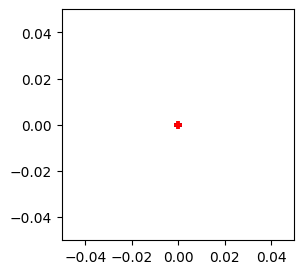

In [11]:
perturbation_radius = 0.05

X_train_adv = attack_tree(*tree.get_abc(), X_train, y_train, max_depth=tree.max_depth, perturbation_radius=perturbation_radius)

print("Train accuracy before:", tree.score(X_train, y_train))
print("Train accuracy after:", tree.score(X_train_adv, y_train))

plot_estimator(tree, X_train_adv, y_train)

(-0.1, 1.1)

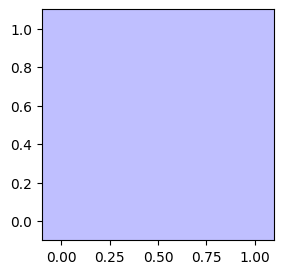

In [12]:
# To further inspect what changes were made to the dataset we visualize only the samples
# that changed prediction and show their positions before and after perturbations were added

i_changed = tree.predict(X_train) != tree.predict(X_train_adv)
X_before = X_train[i_changed]
X_after = X_train_adv[i_changed]
y_changed = y_train[i_changed]

_, ax = plt.subplots(figsize=(3, 3))

steps = 300
colors=("b", "r")

x_low = -0.1
x_high = 1.1
y_low = -0.1
y_high = 1.1

xx, yy = np.meshgrid(
    np.linspace(x_low, x_high, steps), np.linspace(y_low, y_high, steps)
)

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.25, levels=1, colors=colors)
ax.scatter(X_before[y_changed == 0, 0], X_before[y_changed == 0, 1], marker="_", c=colors[0], alpha=0.2)
ax.scatter(X_before[y_changed == 1, 0], X_before[y_changed == 1, 1], marker="+", c=colors[1], alpha=0.2)
ax.scatter(X_after[y_changed == 0, 0], X_after[y_changed == 0, 1], marker="_", c=colors[0])
ax.scatter(X_after[y_changed == 1, 0], X_after[y_changed == 1, 1], marker="+", c=colors[1])

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)

# Robust Optimal Classification Trees demo

This part requires ROCT (`pip install roct`)

In [13]:
from groot.toolbox import Model

from roct.maxsat import SATOptimalRobustTree

ModuleNotFoundError: No module named 'groot'

In [ ]:
# First we train a regular decision tree with CART to compare against
cart_tree = DecisionTreeClassifier(max_depth=3)

cart_tree.fit(X_train, y_train)

plot_estimator(cart_tree, X_train, y_train)

In [ ]:
# Now we train an optimal tree against worst-case perturbations

# Define attack model (l-inf radius in this case)
attack_model = [0.05, 0.05]

robust_tree = SATOptimalRobustTree(max_depth=3, attack_model=attack_model)
robust_tree.fit(X_train, y_train)

plot_estimator(robust_tree, X_train, y_train)

In [ ]:
# Compare the accuracy of the models before and after perturbations
for name, model in zip(
    ["CART", "ROCT"],
    [Model.from_sklearn(cart_tree), Model.from_groot(robust_tree)],
):
    print(name)

    accuracy = model.accuracy(X_test, y_test)
    adversarial_accuracy = model.adversarial_accuracy(X_test, y_test, epsilon=attack_model[0])

    print("Accuracy:", accuracy)
    print("Accuracy against attacks:", adversarial_accuracy)
    print()